In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda, BatchNormalization, merge
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.engine import Input, Model
from keras.optimizers import SGD
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras.backend as K
import json
import time
import  matplotlib.pyplot as plt
from PIL import Image
import matplotlib
import itertools
from keras import regularizers

Using TensorFlow backend.


In [3]:
#setting  the  seed for nummy_gennerated random numbers
np.random.seed(23)
#seting the seed for tensorflow random numbers
tf.set_random_seed(50)

In [4]:
train_path = '.\MAKEUP\Train' 
valid_path = '.\MAKEUP\Valid' 
#test_path = '.\CASIA1\Test' 

In [5]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size = (112,112), classes = ['MakeUp','Normal'], batch_size =8)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size = (112,112), classes = ['MakeUp','Normal'], batch_size = 8)

Found 604 images belonging to 2 classes.
Found 154 images belonging to 2 classes.


In [6]:
# plots images with labels  within jupyter notebook

def plots(ims, figsize = (12,6), rows=1, interp =False , titles = None):
    if  type(ims[0]) is  np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] !=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize = figsize) 
    cols = len(ims)// rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')
        plt.show()
        

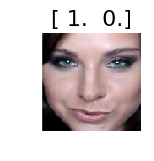

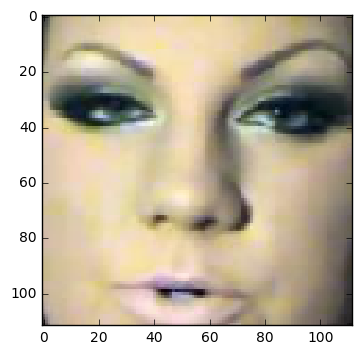

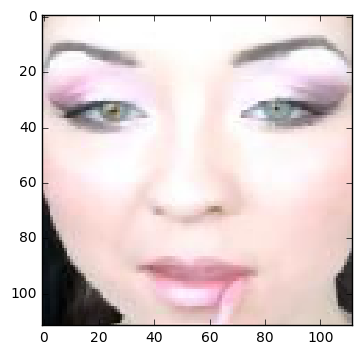

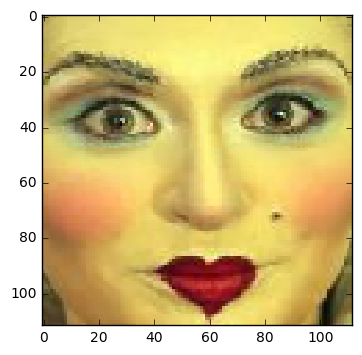

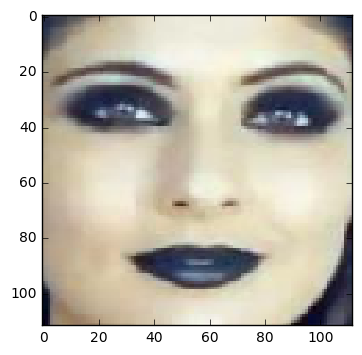

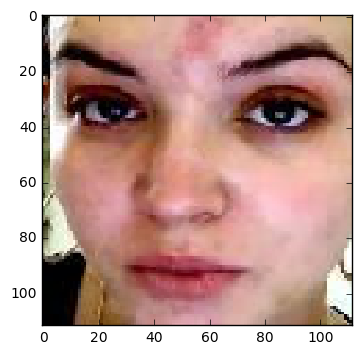

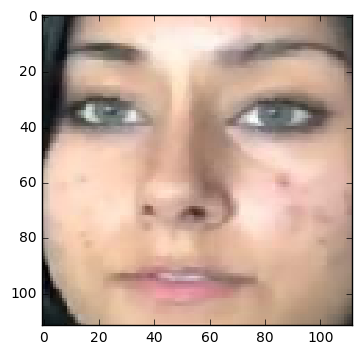

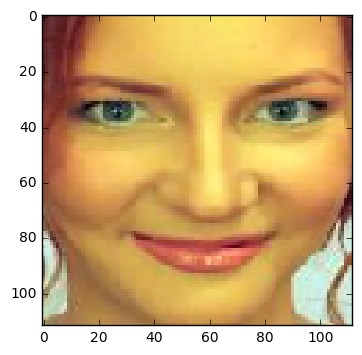

In [7]:
imgs, labels = next(train_batches)
plots(imgs, titles = labels)

In [8]:
# we reduce # filters by factor of 8 compared to original inception-v4
nb_filters_reduction_factor = 8
nb_classes =2 


def inception_v4_stem(x):
    # in original inception-v4, conv stride is 2
    x = Convolution2D(32//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(x)
    x = Convolution2D(32//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(x)
    x = Convolution2D(64//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    
    # in original inception-v4, stride is 2
    a = MaxPooling2D((3, 3), strides=(1, 1), border_mode='valid', dim_ordering='tf')(x)
    # in original inception-v4, conv stride is 2
    b = Convolution2D(96//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(x)
    x = merge([a, b], mode='concat', concat_axis=-1)
    
    a = Convolution2D(64//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    a = Convolution2D(96//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(a)
    b = Convolution2D(64//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    b = Convolution2D(64//nb_filters_reduction_factor, 7, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(b)
    b = Convolution2D(64//nb_filters_reduction_factor, 1, 7, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(b)
    b = Convolution2D(96//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(b)
    x = merge([a, b], mode='concat', concat_axis=-1)
    
    # in original inception-v4, conv stride should be 2
    a = Convolution2D(192//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(x)
    # in original inception-v4, stride is 2
    b = MaxPooling2D((3, 3), strides=(1, 1), border_mode='valid', dim_ordering='tf')(x)
    x = merge([a, b], mode='concat', concat_axis=-1)
    
    return x


def inception_v4_A(x):
    a = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same', dim_ordering='tf')(x)
    a = Convolution2D(96//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(a)
    
    b = Convolution2D(96//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    
    c = Convolution2D(64//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    c = Convolution2D(96//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(c)
    
    d = Convolution2D(64//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    d = Convolution2D(96//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(d)
    d = Convolution2D(96//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(d)
    
    x = merge([a, b, c, d], mode='concat', concat_axis=-1)
    
    return x


def inception_v4_reduction_A(x):
    a = MaxPooling2D((3, 3), strides=(2, 2), border_mode='valid', dim_ordering='tf')(x)
    b = Convolution2D(384//nb_filters_reduction_factor, 3, 3, subsample=(2, 2), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(x)
    c = Convolution2D(192//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    c = Convolution2D(224//nb_filters_reduction_factor, 3, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(c)
    c = Convolution2D(256//nb_filters_reduction_factor, 3, 3, subsample=(2, 2), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(c)
    
    x = merge([a, b, c], mode='concat', concat_axis=-1)
    
    return x
    

def inception_v4_B(x):
    a = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same', dim_ordering='tf')(x)
    a = Convolution2D(128//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(a)
    
    b = Convolution2D(384//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    
    c = Convolution2D(192//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    c = Convolution2D(224//nb_filters_reduction_factor, 1, 7, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(c)
    c = Convolution2D(256//nb_filters_reduction_factor, 1, 7, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(c)
    
    d = Convolution2D(192//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    d = Convolution2D(192//nb_filters_reduction_factor, 1, 7, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(d)
    d = Convolution2D(224//nb_filters_reduction_factor, 7, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(d)
    d = Convolution2D(224//nb_filters_reduction_factor, 1, 7, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(d)
    d = Convolution2D(256//nb_filters_reduction_factor, 7, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(d)
    
    x = merge([a, b, c, d], mode='concat', concat_axis=-1)
    
    return x


def inception_v4_reduction_B(x):
    a = MaxPooling2D((3, 3), strides=(2, 2), border_mode='valid', dim_ordering='tf')(x)
    b = Convolution2D(192//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    b = Convolution2D(192//nb_filters_reduction_factor, 3, 3, subsample=(2, 2), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(b)
    c = Convolution2D(256//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    c = Convolution2D(256//nb_filters_reduction_factor, 1, 7, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(c)
    c = Convolution2D(320//nb_filters_reduction_factor, 7, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(c)
    c = Convolution2D(320//nb_filters_reduction_factor, 3, 3, subsample=(2, 2), activation='relu',
                      init='he_normal', border_mode='valid', dim_ordering='tf')(c)
    
    x = merge([a, b, c], mode='concat', concat_axis=-1)
    
    return x


def inception_v4_C(x):
    a = AveragePooling2D((3, 3), strides=(1, 1), border_mode='same', dim_ordering='tf')(x)
    a = Convolution2D(256//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(a)
    
    b = Convolution2D(256//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    
    c = Convolution2D(384//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    c1 = Convolution2D(256//nb_filters_reduction_factor, 1, 3, subsample=(1, 1), activation='relu',
                       init='he_normal', border_mode='same', dim_ordering='tf')(c)
    c2 = Convolution2D(256//nb_filters_reduction_factor, 3, 1, subsample=(1, 1), activation='relu',
                       init='he_normal', border_mode='same', dim_ordering='tf')(c)
    
    d = Convolution2D(384//nb_filters_reduction_factor, 1, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(x)
    d = Convolution2D(448//nb_filters_reduction_factor, 1, 3, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(d)
    d = Convolution2D(512//nb_filters_reduction_factor, 3, 1, subsample=(1, 1), activation='relu',
                      init='he_normal', border_mode='same', dim_ordering='tf')(d)
    d1 = Convolution2D(256//nb_filters_reduction_factor, 3, 1, subsample=(1, 1), activation='relu',
                       init='he_normal', border_mode='same', dim_ordering='tf')(d)
    d2 = Convolution2D(256//nb_filters_reduction_factor, 1, 3, subsample=(1, 1), activation='relu',
                       init='he_normal', border_mode='same', dim_ordering='tf')(d)
    
    x = merge([a, b, c1, c2, d1, d2], mode='concat', concat_axis=-1)
    
    return x

In [9]:
%%time

img_rows, img_cols = 112, 112
img_channels = 3

# in original inception-v4, these are 4, 7, 3, respectively
num_A_blocks = 1
num_B_blocks = 1
num_C_blocks = 1

inputs = Input(shape=(img_rows, img_cols, img_channels))

x = inception_v4_stem(inputs)
for i in range(num_A_blocks):
    x = inception_v4_A(x)
x = inception_v4_reduction_A(x)
for i in range(num_B_blocks):
    x = inception_v4_B(x)
x = inception_v4_reduction_B(x)
for i in range(num_C_blocks):
    x = inception_v4_C(x)

x = AveragePooling2D(pool_size=(4, 4), strides=(1, 1), border_mode='valid', dim_ordering='tf')(x)
x = Dropout(0.5)(x)
x = Flatten()(x)

# predictions = Dense(nb_classes, activation='softmax')(x)   %%%% default algorithms

predictions = Dense(nb_classes, activation = 'linear', kernel_regularizer=regularizers.l2(0.001))(x) # replace by SVM

model = Model(input=inputs, output=predictions)

C:\Users\hoanganh\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (3, 3), strides=(1, 1), kernel_initializer="he_normal", data_format="channels_last", activation="relu", padding="valid")`
C:\Users\hoanganh\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, (3, 3), strides=(1, 1), kernel_initializer="he_normal", data_format="channels_last", activation="relu", padding="valid")`
C:\Users\hoanganh\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), strides=(1, 1), kernel_initializer="he_normal", data_format="channels_last", activation="relu", padding="same")`
C:\Users\hoanganh\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((3, 3), data_format="channels_last", padding="valid", strid

Wall time: 1.01 s


C:\Users\hoanganh\Anaconda3\lib\site-packages\ipykernel\__main__.py:158: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 1), strides=(1, 1), kernel_initializer="he_normal", data_format="channels_last", activation="relu", padding="same")`
C:\Users\hoanganh\Anaconda3\lib\site-packages\ipykernel\__main__.py:160: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 1), strides=(1, 1), kernel_initializer="he_normal", data_format="channels_last", activation="relu", padding="same")`
C:\Users\hoanganh\Anaconda3\lib\site-packages\ipykernel\__main__.py:162: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 3), strides=(1, 1), kernel_initializer="he_normal", data_format="channels_last", activation="relu", padding="same")`
C:\Users\hoanganh\Anaconda3\lib\site-packages\ipykernel\__main__.py:164: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g

In [10]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 112, 112, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 110, 110, 4)  112         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 108, 108, 4)  148         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 108, 108, 8)  296         conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [11]:
n = len(model.layers)
for idx, layer in enumerate(model.layers):
    if idx < (n-2): 
           layer.trainable = True   
    else:
           layer.trainable = True  

In [ ]:

#### compile with Adam 
opt = Adam(lr=0.0001, decay=10e-6)
model.compile(loss='hinge', optimizer=opt, metrics=['accuracy'])

In [ ]:
### training    
from keras.callbacks import ModelCheckpoint
# Save check point
filepath = "Inception_v4.weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose =1, save_best_only = True, mode ='max')
callbacks_list= [checkpoint]
 # Fit the model
# model.fit(X,Y, validation_split=0.33, nb_epoch =150, batch_size =10, callbacks = callbacks_list, verbose =0)

history = model.fit_generator(train_batches, steps_per_epoch = 76, validation_data = valid_batches, validation_steps=32, epochs =200, shuffle=True, callbacks = callbacks_list, verbose =2)

Epoch 1/200
 - 16s - loss: 0.5209 - acc: 0.5082 - val_loss: 0.5025 - val_acc: 0.4960

Epoch 00001: val_acc improved from -inf to 0.49600, saving model to Inception_v4.weights.best.hdf5
Epoch 2/200
 - 11s - loss: 0.5024 - acc: 0.5016 - val_loss: 0.5024 - val_acc: 0.5160

Epoch 00002: val_acc improved from 0.49600 to 0.51600, saving model to Inception_v4.weights.best.hdf5
Epoch 3/200
 - 11s - loss: 0.5023 - acc: 0.5000 - val_loss: 0.5023 - val_acc: 0.4920

Epoch 00003: val_acc did not improve
Epoch 4/200


In [ ]:
# plot history 
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc= 'upper left' )
plt.show()